In [ ]:
# With BigQuery DataFrames, you can use many familiar Pandas methods, but the
# processing happens in BigQuery rather than the runtime, allowing you to work with larger
# DataFrames that would otherwise not fit in the runtime memory.
# Learn more here: https://cloud.google.com/python/docs/reference/bigframes/latest
!pip install category_encoders
import bigframes.pandas as bf

bf.options.bigquery.location = "us-east1" #this variable is set based on the dataset you chose to query
bf.options.bigquery.project = "jpmc2-468719" #this variable is set based on the dataset you chose to query

In [ ]:
df = bf.read_gbq("jpmc2-468719.Delaware_Checkbook_Expenditure.Expenditure") #this variable is set based on the dataset you chose to query

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [ ]:
df[:20]

,FISCAL YEAR,FISCAL PERIOD,DEPARTMENT,DIVISION,VENDOR,BUDGET_REF,FUND_TYPE,FUND,FUND_DESCR,DEPTID,...,SCH_CODE_DESCR,PC_BU,PC_BU_DESCR,PROJECT,PROJECT_DESCR,ACTIVITY,ACTIVITY_DESCR,CHECK_NUMBER,CHECK_DATE,AMOUNT
0,2024,7,DEPT OF EDUCATION,BRANDYWINE SCHOOL DISTRICT,OTHER EMPLOYMENT COSTS BENEFITS,2024,GENERAL,100,General Fund,953100,...,Talley Middle School,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,PAYROLL,2024-01-12,-3.23
1,2023,3,DEPT OF HEALTH & SOCIAL SVS,ADMINISTRATION/COMMUNITY SVCS,DHSS DIV OF STATE SERV CTRS,2021,FEDERAL,225,Federal Funds,351401,...,<NA>,35000,Dept of Health & Soc Servs,000000000015832,FY 21 Title III C-1 Admin,DHSS_ADMIN,GM35-ADMINISTRATION,Z0000138360,2022-09-16,1817.7
2,2021,2,DEPT OF EDUCATION,CAPE HENLOPEN SCHOOL DISTRICT,EMPLOYEE COMPENSATION,2021,SPECIAL,270,Local Funds,951700,...,Rehoboth Elem School,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,PAYROLL,2020-08-28,1043.48
3,2024,11,DEPT OF EDUCATION,LAUREL SCHOOL DISTRICT,OTHER EMPLOYMENT COSTS BENEFITS,2024,SPECIAL,270,Local Funds,951600,...,To Be Allocated,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,PAYROLL,2024-05-17,745.21
4,2023,8,DEPT OF EDUCATION,APPOQUINIMINK SCHOOL DISTRICT,OTHER EMPLOYMENT COSTS BENEFITS,2023,SPECIAL,270,Local Funds,952900,...,Brick Mill Elem School,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,PAYROLL,2023-02-24,3.23
5,2021,8,DEPT OF NATRL RES AND ENV CONT,WASTE AND HAZARDOUS SUBSTANCES,OTHER EMPLOYMENT COSTS BENEFITS,2021,SPECIAL,100,General Fund,400404,...,<NA>,40000,Dept of Natural Resources,000000000012499,FFY18 Core Grant,DNREC_FED,GM40-DNREC FEDERAL,PAYROLL,2021-02-26,33.79
6,2021,11,DEPT OF EDUCATION,CHRISTINA SCHOOL DISTRICT,WILCOX LANDSCAPING,2020,CAPITAL,300,Capital Projects,953300,...,Christina Central Office,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0001852274,2021-05-06,143.52
7,2022,6,DEPT OF EDUCATION,COLONIAL SCHOOL DISTRICT,OTHER EMPLOYMENT COSTS BENEFITS,2021,FEDERAL,225,Federal Funds,953400,...,Wilbur Elem School,95000,Department of Education,000000000016263,Colonial Title II #13-21,TITLEII_TQ,GM95-TITLE II IMPROVING TQ,PAYROLL,2021-12-30,0.03
8,2022,8,DEPT OF STATE,DEL COMM. OF VETERANS AFFAIRS,DIV OF ACCOUNTING,2022,SPECIAL,100,General Fund,200102,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,PCA,2022-02-04,18.0
9,2021,6,DEPT OF EDUCATION,INDIAN RIVER SCHOOL DISTRICT,OTHER EMPLOYMENT COSTS BENEFITS,2021,GENERAL,100,General Fund,953600,...,Georgetown Middle School,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,PAYROLL,2020-12-31,16.13


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Select relevant columns for anomaly detection
data = df[['AMOUNT', 'FISCAL YEAR', 'FISCAL PERIOD', "DEPARTMENT", "DIVISION", "VENDOR", "ACCOUNT_DESCR"]]

# Convert BigQuery DataFrame to Pandas DataFrame for Isolation Forest
data_pd = data.to_pandas()


In [ ]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=["DEPARTMENT", "DIVISION", "VENDOR", "ACCOUNT_DESCR"])
data_encoded = encoder.fit_transform(data_pd)

Detected Anomalies:
             AMOUNT  FISCAL YEAR  FISCAL PERIOD  DEPARTMENT_0  DEPARTMENT_1  \
338024     50181.64         2024              5             1             0   
362956        300.0         2021              4             1             0   
462726        300.0         2021              4             1             0   
534759     164500.0         2024              3             1             0   
537598       2750.0         2026              1             1             0   
...             ...          ...            ...           ...           ...   
11170599     2676.5         2022             11             1             0   
11173165      171.0         2022              2             1             0   
11177803  241093.56         2021             12             1             0   
11184327     115.87         2024             12             1             0   
11188797      378.0         2021             10             1             0   

          DEPARTMENT_2  DEPARTM

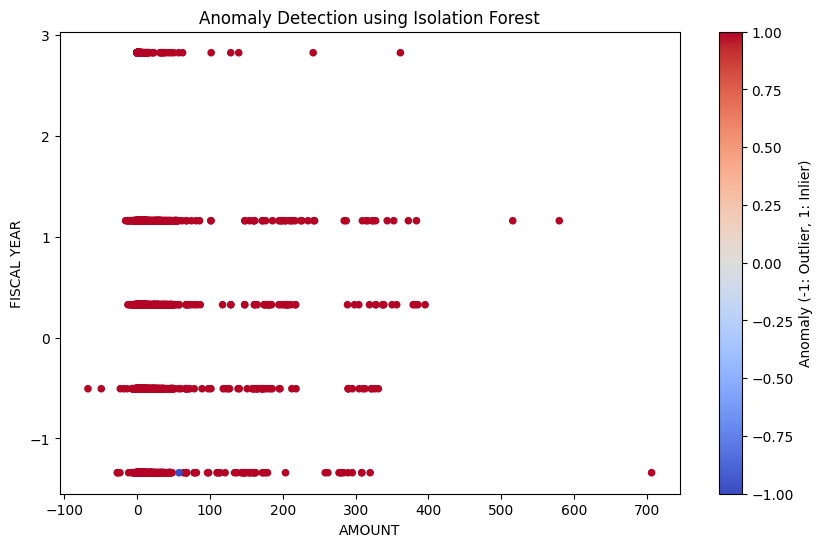

In [ ]:

# Handle potential missing values (e.g., fill with median or mean)
for col in data_encoded.columns:
    if data_encoded[col].isnull().any():
        if data_encoded[col].dtype in ['int64', 'float64']:
            data_encoded[col] = data_encoded[col].fillna(data_encoded[col].median())
        else:
            data_encoded[col] = data_encoded[col].fillna(data_encoded[col].mode()[0])

# Scale numerical features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded.loc[:, ~data_encoded.columns.isin(["DEPARTMENT", "DIVISION", "VENDOR", "ACCOUNT_DESCR"])])

# Initialize and train the Isolation Forest model
# You might need to tune the 'contamination' parameter based on your data and domain knowledge
model = IsolationForest(random_state=42, contamination=0.0001) # Assuming 0.001% anomalies
model.fit(scaled_data)

# Predict anomalies (-1 for outliers, 1 for inliers)
data_encoded['anomaly'] = model.predict(scaled_data)

# Filter for anomalies
anomalies = data_encoded[data_encoded['anomaly'] == -1]

print("Detected Anomalies:")
print(anomalies)

# Optional: Visualize anomalies (for 2D or 3D data)
if scaled_data.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=data_encoded['anomaly'], cmap='coolwarm', s=20)
    plt.title('Anomaly Detection using Isolation Forest')
    plt.xlabel(data_encoded.columns[0])
    plt.ylabel(data_encoded.columns[1])
    plt.colorbar(label='Anomaly (-1: Outlier, 1: Inlier)')
    plt.show()

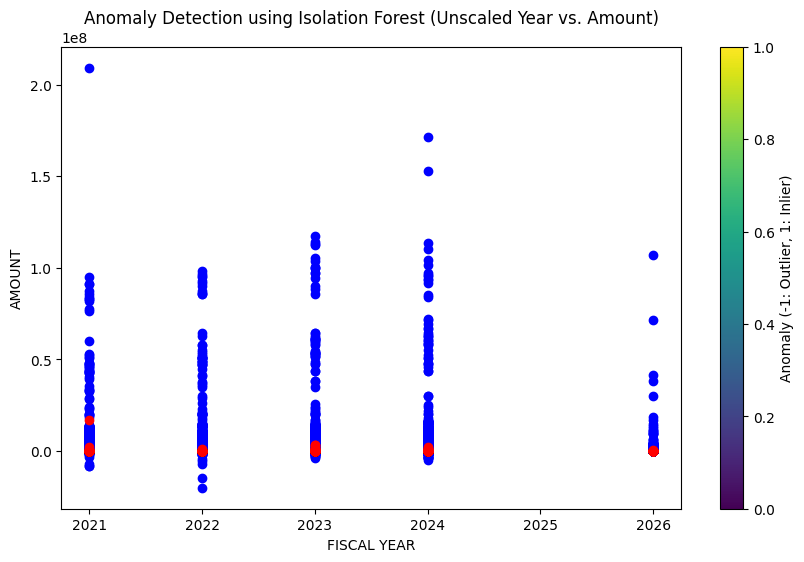

In [ ]:
# if scaled_data.shape[1] >= 2:
#     plt.figure(figsize=(10, 6))
#     plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=data_encoded['anomaly'], cmap='coolwarm', s=20)
#     plt.title('Anomaly Detection using Isolation Forest')
#     plt.xlabel(data_encoded.columns[0])
#     plt.ylabel(data_encoded.columns[1])
#     plt.colorbar(label='Anomaly (-1: Outlier, 1: Inlier)')
#     plt.show()


import matplotlib.pyplot as plt
if scaled_data.shape[1] >= 2:
    plt.figure(figsize=(10, 6))
    plt.scatter(data_encoded[data_encoded["anomaly"] == 1]['FISCAL YEAR'], data_encoded[data_encoded["anomaly"] == 1]['AMOUNT'], c='blue')
    plt.scatter(data_encoded[data_encoded["anomaly"] == -1]['FISCAL YEAR'], data_encoded[data_encoded["anomaly"] == -1]['AMOUNT'], c='red')
    plt.title('Anomaly Detection using Isolation Forest (Unscaled Year vs. Amount)')
    plt.xlabel('FISCAL YEAR')
    plt.ylabel('AMOUNT')
    plt.colorbar(label='Anomaly (-1: Outlier, 1: Inlier)')
    plt.show()

In [ ]:
anomaly_indices = anomalies.index
# print(anomaly_indices)
full_anomalies = data_pd[data_pd.index.isin(anomaly_indices)][(data_encoded['anomaly']==-1)]
full_anomalies

/tmp/ipython-input-27-660990345.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  full_anomalies = data_pd[data_pd.index.isin(anomaly_indices)][(data_encoded['anomaly']==-1)]


,AMOUNT,FISCAL YEAR,FISCAL PERIOD,DEPARTMENT,DIVISION,VENDOR,ACCOUNT_DESCR
338024,50181.64,2024,5,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,CONCORD ACQUISITION CORP,CORP. FRANCHISE TAX
362956,300.0,2021,4,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,"TMF USA, INC.",CORP. FRANCHISE TAX
462726,300.0,2021,4,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,"TMF USA, INC.",CORP. FRANCHISE TAX
534759,164500.0,2024,3,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,Property Solutions Acquisition Corp. II,CORP. FRANCHISE TAX
537598,2750.0,2026,1,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,FAMILY PROMISE OF SOUTHERN DELAWARE INC,GRANTS IN AID
...,...,...,...,...,...,...,...
11170599,2676.5,2022,11,OTHER ELECTIVE OFFICES,RECONCILIATION AND TRANSACTION,"SMITH, MICHAEL C & PATRICIA H",MISCELLANEOUS EXPENSES
11173165,171.0,2022,2,OTHER ELECTIVE OFFICES,RECONCILIATION AND TRANSACTION,"SMITH, STEPHANIE J",MISCELLANEOUS EXPENSES
11177803,241093.56,2021,12,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,"AXIOMSL GROUP, INC.",CORP. FRANCHISE TAX
11184327,115.87,2024,12,OTHER ELECTIVE OFFICES,REFUNDS & GRANTS,SURETEC INSURANCE COMPANY,REVENUE REFUND


In [ ]:
anomalies[(anomalies['AMOUNT']>25) & (anomalies['AMOUNT']<75) & (data_encoded['FISCAL YEAR']==2021)].index